In [54]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import scipy.stats as stats

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import shapely.geometry as sg
from shapely.geometry import Point

import sys
sys.path.append(os.path.abspath(".."))
from function import DOWN_raw
from function import ART_preprocessing as ART_pre

import warnings
warnings.filterwarnings('ignore')

In [55]:
lon_min, lon_max, lat_min, lat_max, area, toll = 6.5, 19, 36.5, 48, 'ITALY', 0.002

Tr = [5, 10, 20, 50, 100]
Fi = 1 - 1/np.array(Tr)

In [56]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [57]:
obs_base = os.path.join('/','media','arturo','T9','Data','Italy', 'stations', 'Italy_raingauges')
sat_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_DOWN')

In [58]:
METADATA = pd.read_csv(os.path.join(obs_base, 'METADATA', 'METADATA_INTENSE_NOQC_update.csv'))
METADATA.head(2)

,File,ISO,Region,Code,Name,Elevation,Orig_EPSG,CRS_E,CRS_N,Lat,Lon,Year_Start,Year_End,INTENSE_Resp,AGENCY,Source,TimeZone,Agency
0,IT-210_PIE-001030-900_0060.csv,IT-210,Piedmont,PIE-001030-900,BORGOFRANCODIVREA,337.0,32632.0,410005.0,5040731.0,45.514302,7.847798,1988-05-08 05:00:00,2024-09-09 01:00:00,DT,ARPA Piemonte,Piedmont,UTC,NaN
1,IT-210_PIE-001097-900_0060.csv,IT-210,Piedmont,PIE-001097-900,CUMIANA,327.0,32632.0,373092.0,4980177.0,44.963696,7.390821,1988-01-29 03:00:00,2024-09-18 12:00:00,DT,ARPA Piemonte,Piedmont,UTC,NaN


## Load ENSEMBLE data

In [59]:
dir_in = os.path.join(sat_base,'ITALY_ENSEMBLE_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc')
data = xr.open_dataset(dir_in)

lat_sat = data.lat.values
lon_sat = data.lon.values
lon2d_sat, lat2d_sat = np.meshgrid(lon_sat, lat_sat)

Sat_year = data.year.values

Sat_NYd = data.NYd.values
Sat_CYd = data.CYd.values
Sat_WYd = data.WYd.values

## Choose the Region

In [60]:
regions_ISO = sorted(METADATA['ISO'].unique())
region_ = regions_ISO[0]
print(f'Region: {region_}') 

Region: IT-210


In [89]:
METADATA_clear = METADATA[METADATA['ISO']==region_].reset_index(inplace=False)

RE_50 = []
for nn in range(len(METADATA_clear)):#len(METADATA_clear)
    filename = f'{METADATA_clear['File'].values[nn]}'
    lat_obs = METADATA_clear['Lat'][nn]
    lon_obs = METADATA_clear['Lon'][nn]

    OBS_pd = pd.read_csv(os.path.join(obs_base, 'DATA_1dy', 'statistics', region_, filename))
    OBS_pd = OBS_pd[(OBS_pd['Year']>=2002)&(OBS_pd['Year']<=2023)].reset_index(drop=True)

    OBS_N = OBS_pd['N'].values
    OBS_C = OBS_pd['C'].values
    OBS_W = OBS_pd['W'].values
    OBS_Y = OBS_pd['Year'].values

    x0 = np.nanmean(OBS_C)
    OBS_Q, flag = DOWN_raw.mev_quant_update(Fi, x0, OBS_N, OBS_C, OBS_W, thresh=1)
    OBS_Q2 = np.where(flag, OBS_Q, np.nan)

    distances = ART_pre.haversine(lat2d_sat, lon2d_sat, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    Sat_NYd_ = Sat_NYd[:,min_index[0],min_index[1]]
    Sat_CYd_ = Sat_CYd[:,min_index[0],min_index[1]]
    Sat_WYd_ = Sat_WYd[:,min_index[0],min_index[1]]

    Sat_pd = pd.DataFrame({'Year':Sat_year, 'N':Sat_NYd_, 'C':Sat_CYd_, 'W':Sat_WYd_})
    # Sat_pd_filtered = Sat_pd[Sat_pd['Year'].isin(OBS_pd['Year'])]
    Sat_pd_filtered = Sat_pd.set_index('Year').loc[OBS_pd['Year']].reset_index()

    SAT_N = Sat_pd_filtered['N'].values
    SAT_C = Sat_pd_filtered['C'].values
    SAT_W = Sat_pd_filtered['W'].values
    SAT_Y = Sat_pd_filtered['Year'].values
    
    if len(OBS_Y) != len(SAT_Y):
        print('ERROR')
        sys.exit()
    else:
        x0 = np.nanmean(SAT_C)
        SAT_Q, flag = DOWN_raw.mev_quant_update(Fi, x0, SAT_N, SAT_C, SAT_W, thresh=1)
        SAT_Q2 = np.where(flag, SAT_Q, np.nan)
    
    relative_e_50 = (SAT_Q2[3] - OBS_Q2[3])/OBS_Q2[3]
    RE_50.append(float(relative_e_50))

Text(0.0, 1.0, 'Region IT-210')

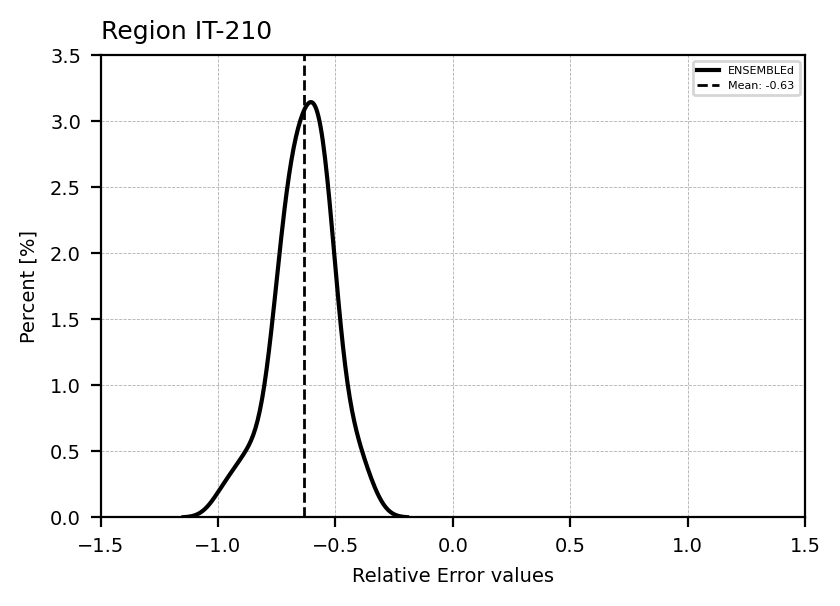

In [92]:
fig = plt.figure(figsize=(10,3),dpi=200)
gs = gridspec.GridSpec(1,2)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(RE_50,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLEd')
ax1.axvline(np.mean(RE_50),color='k',linestyle='--',linewidth=1, label=f'Mean: {np.round(np.mean(RE_50),2)}')

ax1.legend(fontsize=4, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,3.5)
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_ylabel('')
ax1.set_xlabel('Relative Error values',fontsize=7) 
ax1.set_ylabel('Percent [%]',fontsize=7)

ax1.set_title(f'Region {region_}', fontsize=9, loc='left')

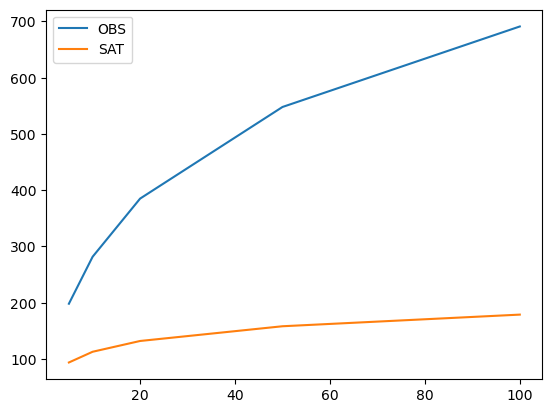

In [93]:
plt.plot(Tr, OBS_Q2, label='OBS')
plt.plot(Tr, SAT_Q2, label='SAT')
plt.legend()

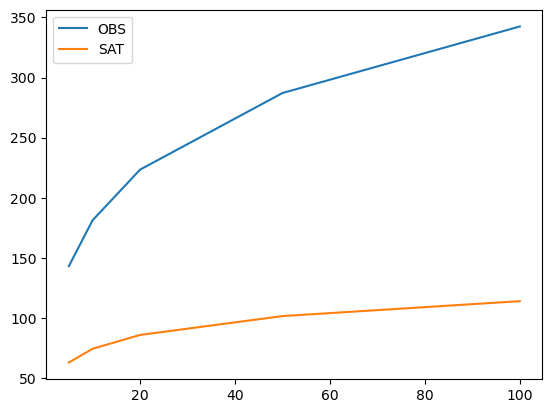

In [63]:
plt.plot(Tr, OBS_Q2, label='OBS')
plt.plot(Tr, SAT_Q2, label='SAT')
plt.legend()

In [64]:
TMP_Q2

array([109.38683389, 148.52784573, 215.13824287, 335.16718169,
       436.98312057])

In [65]:
Sat_pd

,Year,N,C,W
0,2002,135.500000,5.742154,0.758284
1,2003,96.166667,4.436469,0.768746
2,2004,102.833333,4.816773,0.755025
3,2005,98.166667,4.900935,0.761240
4,2006,117.166667,4.238214,0.703778
5,2007,118.166667,4.997718,0.829142
6,2008,139.000000,5.967207,0.793423
7,2009,128.500000,5.646119,0.801471
8,2010,133.666667,5.868656,0.715653
9,2011,112.166667,6.727721,0.709132
